# Natural Language Processing 

### What is Natural Language Processing?

**Natural language processing** (NLP) is basically getting computers to understand language the way that we do. Natural language processing has many applications including:
- voice-to-text services
- text-to-voice services 
- automated chatbots 
- translation services

#### Today we are just covering the tip of the iceberg when it comes to NLP. However, we'll cover some useful tools that will allow you to pre-process and vectorize our text so our computer can understand it, then use it in a machine learning model. We'll also talk about sentiment analysis and key word identification.

### So, what are we doing today?

- Extract features from unstructured text by fitting and transforming with `CountVectorizer`.
- Discuss text data preprocessing options
- Describe how CountVectorizers
- Understand CountVectorizer Hyperparameters
- Implement `CountVectorizer` and `Random Forest Classifier` for tweet classification.
- Use `GridSearchCV` and `Pipeline` with `CountVectorizer`.
- Using `VADER` for sentiment analysis
- Using some Regex for data cleaning and keyword extraction

In [317]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer

# easier to see full text with a bigger maxwidth:
pd.options.display.max_colwidth = 200

# Text Feature Extraction 

When building a machine learning model, we know that take in an `X` and a `y` variable.
- `X` is a matrix/dataframe of real numbers.
- `y` is a vector/series of real numbers.

Text data (also called natural language data) isn't structured in this way. It's not cleany organized as a matrix of numbers. It is **unstructured data**. So, our job is to find a logical way to convert our text into numbers, so that our computers can understand it. Luckily we have a couple of tools are our disposal to do this!

# Disaster Classification Model

Can we predict which tweets are about real disasters and which are fake?

- This data set was taken from Kaggle: https://www.kaggle.com/competitions/nlp-getting-started/overview

In [318]:
# Read in data.
disaster = pd.read_csv('./data/disaster.csv')

# Check out first five rows.

disaster.head()

# 1: Real Disaster Tweet
# 2: Fake Diaster Tweet


,tweet,status
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [319]:
disaster[disaster['status'] == 0][:20]

,tweet,status
15,What's up man?,0
16,I love fruits,0
17,Summer is lovely,0
18,My car is so fast,0
19,What a goooooooaaaaaal!!!!!!,0
20,this is ridiculous....,0
21,London is cool ;),0
22,Love skiing,0
23,What a wonderful day!,0
24,LOOOOOOL,0


In [320]:
disaster.head()

,tweet,status
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [321]:
disaster.shape

(7613, 2)

<details><summary>In this situation, what is our target variable? What are our features?</summary>
    
- We're trying to predict if it's a real or fake tweet, so our target is the 'status' column
    - 0: Fake
    - 1: Real
- Our features are the words in the tweet!!
</details>




## Quick Aside: Terminology

---

- A collection of text is a **document**. 
    - You can think of a document as a row in your feature matrix.
- A collection of documents is a **corpus**. 
    - You can think of your full dataframe as the corpus.

Let's set up our data for modeling:
- `X` will be the `tweet` column. 

**NOTE**: `CountVectorizer` requires a vector, so make sure you set `X` to be a `pandas` Series, **not** a DataFrame.
- `y` will be the `status` column

In [322]:
X = disaster['tweet']
y = disaster['status']

In [323]:
# Check what we need to check in a classification problem.
y.value_counts(normalize = True)

##What is our baseline accuracy?

0    0.57034
1    0.42966
Name: status, dtype: float64

In [324]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

# Pre-Processing 

When dealing with text data, there are common pre-processing steps. We won't necessarily use all of them every time we deal with text data.

- Remove special characters
- Tokenizing
- Lemmatizing/Stemming
- Stop word removal

There are ways to do this using other tools like Regex, but our text vectorizers `CountVectorizer` can also do this for us! That is what we will do today, but let's talk about what these preprocessing steps mean.

#### Removing special characters: 
- We will often want to remove unnecessary characters when cleaning text data (punctuation, symbols, etc.). This can be done with RegEx or with our vectorizers.
#### Tokenizing: 
- When we "tokenize" data, we take it and split it up into distinct chunks based on some pattern. This can be in individual words or groups of words.
#### Lemmatizing/Stemming:
- Lemmatizing and stemming are two forms of shortening words so we can combine similar forms of the same word.
    - When we "lemmatize" data, we take words and attempt to return their lemma, or the base/dictionary form of a word.
    - When we "stem" data, we take words and attempt to return a base form of the word. It tends to be cruder than using lemmatization. 
#### Stop Word Removal:
- Stop Words are words that show up in text so often, that they generally aren't good predictors. These are words like 'the', 'and, 'but', etc.

### Quick Example of Lemmatizing and Stemming:

In [325]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [332]:
# Instantiate lemmatizer.
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('running')

'running'

In [333]:
# Instantiate PorterStemmer.
p_stemmer = PorterStemmer()
p_stemmer.stem('running')

'run'

## `CountVectorizer`
---

The most straight forward way to convert text data into a structured, numeric `X` dataframe is to use `CountVectorizer`.

- **Count**: Count up how many times a token is observed in a given document.
- **Vectorizer**: Create a column (also known as a vector) that stores those counts.


<!-- <img src="./images/countvectorizer.png" alt="drawing" width="750"/> -->

[Source](https://towardsdatascience.com/nlp-learning-series-part-2-conventional-methods-for-text-classification-40f2839dd061).

In [341]:
from sklearn.feature_extraction.text import CountVectorizer

# list of text documents
text = ['Lucy is a good dog. She is obsessed with laser pointers.']

cvec = CountVectorizer()
# tokenize and build vocab
cvec.fit(text)

print(cvec.vocabulary_)  

# # # encode document
vector = cvec.transform(text)
# # # summarize encoded vector
print(vector.shape)
print(vector.toarray())

# type(vector)

df = pd.DataFrame(vector.todense(), 
                          columns=cvec.get_feature_names())
df.head()

{'lucy': 4, 'is': 2, 'good': 1, 'dog': 0, 'she': 7, 'obsessed': 5, 'with': 8, 'laser': 3, 'pointers': 6}
(1, 9)
[[1 1 2 1 1 1 1 1 1]]


,dog,good,is,laser,lucy,obsessed,pointers,she,with
0,1,1,2,1,1,1,1,1,1


#### Bag of Words:
   - It's called a bag of words because we lose the structure of our sentences.
   - What are some potential problems with this approach?
   
<details><summary>What might be some of the advantages of using this bag-of-words approach when modeling?</summary>

- Efficient to store.
- Efficient to model.
- Keeps a decent amount of information.
</details>


<details><summary>What might be some of the disadvantages of using this bag-of-words approach when modeling?</summary>

- Since bag-of-words models discard grammar, order, structure, and context, we lose a decent amount of information.
- Phrases like "not bad" or "not good" won't be interpreted properly.
</details>


In [342]:
# Instantiate a CountVectorizer.

cvec = CountVectorizer()

In [343]:
# Fit & transform the vectorizer on our training corpus.

Xc_train = cvec.fit_transform(X_train)

In [344]:
# Transform the test corpus.
Xc_test = cvec.transform(X_test)

In [346]:
Xc_train.shape, Xc_test.shape

((5100, 16490), (2513, 16490))

At this point, we could fit a model using our transformed data, BUT:

- We have increased the dimensionality of our data - because we have 16490 columns, our data is in 16490 dimensions! 
- Because our data has such high dimensionality, we run the risk of overfitting.
- Luckily, there are some hyperparameters in CountVectorizer to help with this

<details><summary>Remind me: what is a hyperparameter?</summary>

- A hyperparameter is a built-in option that affects our model, but our model cannot learn these from our data!
- Examples of hyperparameters include:
    - the value of $k$ and the distance metric in $k$-nearest neighbors,
    - our regularization constants $\alpha$ or $C$ in linear and logistic regression.
</details>

Let's examine some of the different hyperparameters of `CountVectorizer`:
- `stop_words`
- `max_features`, `max_df`, `min_df`
- `ngram_range`
- `strip_accents`

### Stopwords

Let's see what our top-occurring words are right now.

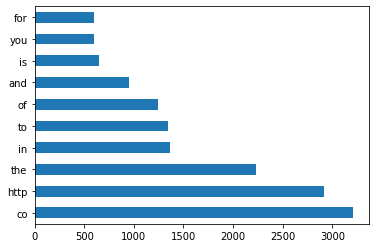

In [347]:
# Convert X_train into a DataFrame.
# We will not actually use this for modeling,
# this is just to visualize what is happening
Xc_train_df = pd.DataFrame(Xc_train.todense(), 
                          columns=cvec.get_feature_names())

Xc_train_df.head()

# plot

Xc_train_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh');


In [184]:
print(CountVectorizer(stop_words = 'english').get_stop_words())

frozenset({'those', 'through', 'but', 'others', 'whereby', 'by', 'never', 'at', 'everywhere', 'upon', 'however', 'anyhow', 'might', 'seems', 'cry', 'whether', 'becoming', 'for', 'hereafter', 'ever', 'someone', 'could', 'former', 'mostly', 'they', 'would', 'bill', 'formerly', 'everything', 'among', 'herein', 'when', 'out', 'system', 're', 'sometime', 'yet', 'anything', 'any', 'had', 'few', 'may', 'yourselves', 'in', 'somewhere', 'via', 'us', 'most', 'who', 'ten', 'because', 'herself', 'once', 'put', 'hasnt', 'was', 'cant', 'with', 'anywhere', 'which', 'should', 'see', 'only', 'while', 'moreover', 'latter', 'anyone', 'meanwhile', 'thus', 'part', 'very', 'be', 'made', 'ourselves', 'get', 'on', 'interest', 'last', 'un', 'each', 'hers', 'something', 'whence', 'find', 'nevertheless', 'me', 'whatever', 'have', 'own', 'less', 'same', 'your', 'etc', 'he', 'thereupon', 'mine', 'him', 'besides', 'both', 'more', 'much', 'one', 'than', 'towards', 'amongst', 'two', 'where', 'his', 'detail', 'is', 's

`CountVectorizer` gives you the option to remove stopwords from your corpus when instantiating your vectorizer.

```python
cvec = CountVectorizer(stop_words='english')
```

You could also pass your own list of stopwords that you'd like to remove.
```python
cvec = CountVectorizer(stop_words=['words', 'to', 'remove'])
```
Or you could add custom stopwords to the built in stopwords:

In [185]:
my_words = ['python', 'kafka', 'project', 'capstone', 'programming']

In [186]:
from sklearn.feature_extraction import text 

stop_words = text.ENGLISH_STOP_WORDS.union(my_words)

stop_words

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

### Vocabulary size

Since we're creating a column for each token in the corpus, our vocabulary and thereby our dataframe can get really large!

There are three hyperparameters to help you control this.

1. `max_features`: will only include the $N$ most common vocabulary words in the corpus.

```python
cvec = CountVectorizer(max_features=1_000) # Only the top 1,000 words from the entire corpus will be saved
```

2. `min_df`: Will only consider words that occur in **at least** $N$ number of documents.

```python
cvec = CountVectorizer(min_df=2) # A word must occur in at least two documents from the corpus
```

3. `max_df` Will only consider words that occur in **at most** some percentage of documents.

```python
cvec = CountVectorizer(max_df=.98) # Ignore words that occur in > 98% of the documents from the corpus
```

<details><summary>Why might we want to control these vocabulary size hyperparameters?</summary>
    
- If we have too many features, our models may take a **very** long time to fit.
- Control for overfitting
- Words in 99% of documents or words occuring in only one document might not be very informative.
</details>

### N-Gram Range
---

`CountVectorizer` has the ability to capture $n$-word phrases, also called $n$-grams. 

> Natural language processing is cool.

In the example sentence, the bigrams are:
- 'Natural language'
- 'language processing'
- 'processing is'
- 'is cool'

The `ngram_range` determines what $n$-grams should be considered as features.

```python
cvec = CountVectorizer(ngram_range=(1,2)) # Captures every 1-gram and every 2-gram
```

<details><summary>Why might we want to change ngram_range to something other than (1,1)?</summary>

- We can work with multi-word phrases like "not good" or "very hot."
</details>

# Modeling, GridsearchCV & Pipelines

<details><summary>Why do we need a pipeline to GridSearch over our CountVectorizer hyperparameters?</summary>
    
- The CountVectorizer is a transformer.
- Transformers have .fit() and .transform() methods, but cannot do .predict().
- In order to GridSearch over hyperparameters, we need some way to score our model performance.
- A pipeline stacks together one or more transformers with an estimator at the end. The estimator allows us to .predict() and get a score!
</details>

In [348]:
from sklearn.ensemble import RandomForestClassifier

In [349]:
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [350]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Random Forest Classifier

pipe = Pipeline([
    ('cvec', CountVectorizer() ),
    ('rfc', RandomForestClassifier())
])

## `GridSearchCV`
---

At this point, you could use your `pipeline` object as a model:

Since we want to tune over the `CountVectorizer`, we'll load our `pipeline` object into `GridSearchCV`.

In [351]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 1500, 2000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).
#max depth of 5, 7
#min sample leaf of 3, 5

pipe_params = {
    'cvec__max_features': [1500, 2000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.90, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'rfc__max_depth' : [5, 7],
    'rfc__min_samples_leaf' : [3, 5]
}

In [352]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  pipe_params, # what parameters values are we searching?
              cv =3) # 3-fold cross-validation.

In [353]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rfc', RandomForestClassifier())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [1500, 2000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'rfc__max_depth': [5, 7],
                         'rfc__min_samples_leaf': [3, 5]})

In [355]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.7047058823529412, 0.7095105451651412)

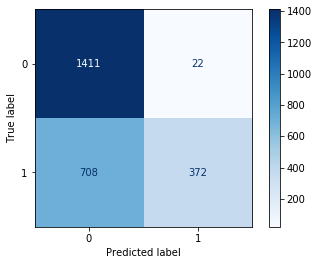

In [358]:
# View confusion matrix
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues');

In [359]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 1500,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'rfc__max_depth': 7,
 'rfc__min_samples_leaf': 5}

In [363]:
#one downside to pipelines: 

# gs.best_estimator_.feature_importance()

# There are some work arounds though: 
#https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214

## Sentiment Analysis with VADER

#### What is Sentiment Analysis?
- Sentiment Analysis is the process of computationally determining whether a piece of text is positive, negative or neutral.
- There are a variety of tools out there to perform sentiment analysis https://www.iflexion.com/blog/sentiment-analysis-python
- Today we're going to focus on the VADER Sentiment Intensity Analyzer from NLTK.

<img src="https://media.giphy.com/media/3ohuPsd2QJlKWmhgSk/giphy.gif" style="float: center; margin: 20px; height: 300px">

### VADER (Valence Aware Dictionary and sEntiment Reasoner):
is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

### Advantages of using VADER

- It works exceedingly well on social media type text, yet readily generalizes to multiple domains
- It's fast and does not severely suffer from a speed-performance tradeoff.
- It takes punctuation and capitalization into account
- It can interpret emojis 

Dataset if from Kaggle: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?select=IMDB+Dataset.csv

In [364]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
#conda install nltk

In [ ]:
# if you get an error with the above code, run this & follow below directions:
#nltk.download()

#import nltk
#nltk.download('all')

In [365]:
movies = pd.read_csv('imdb.csv')

In [366]:
movies.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire p...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenl...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what mone...",positive


In [367]:
movies['review'] = movies['review'].replace('<br /><br />\S+', '', regex=True).replace('/>\S+', '', regex = True)

In [368]:
movies.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me. first thing that struck me about Oz was i...",positive
1,"A wonderful little production. filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. actors a...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i...",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time. movie is slower than a soap opera... and suddenly, Jake decides ...",negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what mone...",positive


## Format Reviews for VADER:

The `SentimentIntensityAnalyzer` will expect a list of strings.

In [291]:
#convert to a list of strings:

corpus = list(movies['review'])
corpus[:2]

["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me. first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word. is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away. would say the main appeal of the show is due to the fact that it goes where other shows wouldn'

## Instantiate `SentimentIntensityAnalyzer` and test it on the first tweet:

In [292]:
#instantiate SIA

sia = SentimentIntensityAnalyzer()


#Get polarity scores for the first tweet

sia.polarity_scores(corpus[2])


{'neg': 0.094, 'neu': 0.686, 'pos': 0.221, 'compound': 0.978}

In [293]:
corpus[2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love. was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman. may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

- The 'compound' score is computed by summing the scores of each word and then is normalized to be between -1 (most extreme negative) and +1 (most extreme positive). 
- This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. 
- Calling it a 'normalized, weighted composite score' is accurate.

Generally:
- positive sentiment : (compound score >= 0.05)
- neutral sentiment : (compound score > -0.05) and (compound score < 0.05)
- negative sentiment : (compound score <= -0.05)

In [369]:
#create dataframe that contains text and the polarity scores for each tweet

sentiment = []    

for review in corpus:
    scores = sia.polarity_scores(review)
    scores['review'] = review
    sentiment.append(scores)

df = pd.DataFrame(sentiment)
df.head()

,compound,neg,neu,pos,review
0,-0.9951,0.207,0.744,0.049,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me. first thing that struck me about Oz was i..."
1,0.9641,0.055,0.764,0.180,"A wonderful little production. filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. actors a..."
2,0.9780,0.094,0.686,0.221,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i..."
3,-0.9213,0.144,0.788,0.068,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time. movie is slower than a soap opera... and suddenly, Jake decides ..."
4,0.9766,0.053,0.788,0.159,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what mone..."


In [295]:
df['target'] = movies['sentiment']

In [296]:
df.head()

,compound,neg,neu,pos,review,target
0,-0.9951,0.207,0.744,0.049,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me. first thing that struck me about Oz was i...",positive
1,0.9641,0.055,0.764,0.180,"A wonderful little production. filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. actors a...",positive
2,0.9780,0.094,0.686,0.221,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i...",positive
3,-0.9213,0.144,0.788,0.068,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time. movie is slower than a soap opera... and suddenly, Jake decides ...",negative
4,0.9766,0.053,0.788,0.159,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what mone...",positive


### Plot score differences between VADER Analysis and Reviewer Report

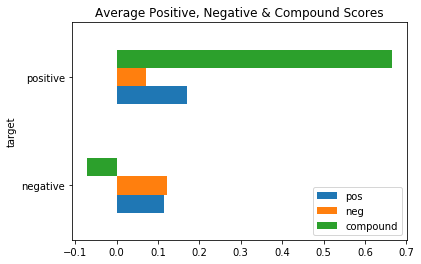

In [297]:
df.groupby('target').mean()[['pos', 'neg', 'compound']].plot(kind='barh')
plt.title('Average Positive, Negative & Compound Scores');

In [206]:
## Modeling Prep

In [207]:
X = df[['text', 'compound']]
y = df['target']

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [ ]:
{'cvec__max_df': 0.99,
 'cvec__max_features': 1500,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'rfc__max_depth': 7,
 'rfc__min_samples_leaf': 3}

In [217]:
cvec = CountVectorizer(stop_words = 'english', 
                       max_features = 1500,
                      max_df = 0.99,
                      min_df = 3,
                      ngram_range = (1, 2))

X_train_cv = cvec.fit_transform(X_train['text'])
X_test_cv = cvec.transform(X_test['text'])

In [218]:
df_X_train = pd.DataFrame(X_train_cv.todense(), columns = cvec.get_feature_names())
df_X_test = pd.DataFrame(X_test_cv.todense(), columns = cvec.get_feature_names())

In [219]:
df_X_train.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
df_X_test.reset_index(drop=True, inplace = True)
X_test.reset_index(drop=True, inplace=True)

In [220]:
X_train_all = pd.concat([df_X_train, X_train], axis =1)
X_test_all = pd.concat([df_X_test, X_test], axis = 1)

X_train_all.drop(columns = 'text', inplace = True)
X_test_all.drop(columns = 'text', inplace = True)

In [221]:
X_train_all.shape, X_test_all.shape, y_train.shape, y_test.shape

((5709, 1500), (1904, 1500), (5709,), (1904,))

In [214]:
from sklearn.ensemble import RandomForestClassifier

In [222]:
rfc = RandomForestClassifier(max_depth = 7, min_samples_leaf = 3)

In [223]:
rfc.fit(X_train_all, y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=3)

In [224]:
rfc.score(X_train_all, y_train), rfc.score(X_test_all, y_test)

(0.6645647223681905, 0.667016806722689)

### Regex For Finding Specific Keys Words in Text

In [373]:
import pandas as pd
d = {'review': ['i love this movie', 'this is the worst movie ever','what did i just watch?',' the worst','my favorite','ugh','absolute worst'] ,'review_num': [1, 2,3,4,5,6,7
]}
df = pd.DataFrame(data=d)  
df.head()

,review,review_num
0,i love this movie,1
1,this is the worst movie ever,2
2,what did i just watch?,3
3,the worst,4
4,my favorite,5


In [378]:
import re
worst = df.review.str.contains('worst', flags = re.IGNORECASE, regex = True, na = False)

In [379]:
df[worst]

,review,review_num
1,this is the worst movie ever,2
3,the worst,4
6,absolute worst,7


### Additional Resources:

Github Resources: https://github.com/cjhutto/vaderSentiment

Academic Paper: http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf

Regex Cheatsheet: https://cheatography.com/davechild/cheat-sheets/regular-expressions/

Tfidf Vectorizer: https://towardsdatascience.com/tf-idf-simplified-aba19d5f5530